## Multi-Word Relevant Expressions LocalMaxs Extractor

From: "A Local Maxima method and a Fair Dispersion Normalization for extracting multi-word units from corpora":

"The availability of **multi-word units (MWUs)** in NLP lexica has important applications:
- enhances parsing precision, 
- helps on attachment decision
- enables more natural interaction of non-specialists users with information retrieval engines"

"Most statistical approaches to MWUs extraction from corpora:
1. measure the association between two words
2. define thresholds for deciding which bigrams may be elected as possible units and
3. use complex linguistic filters and language specific morpho-syntactic rules for filtering those units."


Relevant Expressions:: features with high value

"Thus, more generally, multiword features consist of x number of words occurring within a maximum window size of y (with y ≥ x naturally)." (Weiss2005_Book_TextMining.pdf)

**Local Maxs Algorithm"**:
LocalMaxs Algorithm (Silva & Lopes,99)
Core idea: words combine preferably with limited sets of words, forming cohesion groups. An n‐gram arises as Relevant Expression when its cohesion stands out in the context of its neighborhood.

(From slides)

## Implementation
> Implement the multi-word Relevant Expressions LocalMaxs extractor, taking into account the following requirements:

> a) To obtain tokens, you may add a space character before and/or after characters such as “;”, “:”, “!”, “?”, “<”, “>”, “&”, “)”, “(“, “]”, “[“, among others that do not change the semantics of the text, in order to improve the reliability of token frequencies.

In [2]:
SPECIAL_CHARACTERS = [';', '.', ':', '!', '?', '<', '>',
                      '&', '(', ')', '[', ']', '\n', ',',
                      '}', '{', "'", '"', '-', '\\', '/',
                      '+', '=', '~', '@', '`', '%', '#']

As special characters which we consider as individual tokens we chose:
~	Tilde.
\`	Acute, backquote, backtick, grave, grave accent, left quote, open quote, or a push.
!	Exclamation mark, exclamation point, or bang.
@	Ampersat, arobase, asperand, at, or at symbol.
#	Octothorpe, number, pound, sharp, or hash.
$	Dollar sign or generic currency.
\%	Percent.
^	Caret or circumflex.
&	Ampersand, epershand, or and symbol.
*	Asterisk, mathematical multiplication symbol, and sometimes referred to as a star.
(	Open or left parenthesis.
)	Close or right parenthesis.
-	Hyphen, minus, or dash.
_	Underscore.
+	Plus.
=	Equal.
{	Open brace, squiggly brackets, or curly bracket.
}	Close brace, squiggly brackets, or curly bracket.
[	Open bracket.
]	Closed bracket.
|	Pipe, or, or vertical bar.
\	Backslash or reverse solidus.
/	Forward slash, solidus, virgule, whack, and mathematical division symbol.
:	Colon.
;	Semicolon.
"	Quote, quotation mark, or inverted commas.
'	Apostrophe or single quote.
<	Less than or angle brackets.
>	Greater than or angle brackets.
,	Comma.
.	Period, dot, or full stop.
?	Question mark.

In [54]:
def separate_special_tokens(string):
    for char in SPECIAL_CHARACTERS:
        string = string.replace(char, f" {char} ")
    return string

In [55]:
# Test separate_special_tokens
a = "&b!ld"
print(separate_special_tokens(a))

 & b ! ld


In [58]:
def tokenize(string):
    tokens = separate_special_tokens(string).split(' ')
    # don't return empty strings
    return list(filter(None, tokens))

### Load Corpus
Load corpus document into dict with split tokens for each document. This datastructure choice allows for later calculating document specific measures, such as e.g. *Tf_Idf*.

In [60]:
from pathlib import Path
from collections import defaultdict
import os
CORPUS_PATH = "./corpus2mw"

corpus = defaultdict(list)

# open all files starting with "fil" in corpus path
for doc_path in Path(CORPUS_PATH).glob('fil_*'):
    
    # read whole document and strip new lines
    doc = Path(doc_path).read_text().replace('\n', '')
    
    doc_name = os.path.basename(doc_path)
    corpus[doc_name] = tokenize(doc)

### Implement Cohesion Metrics

> c) Let it be possible to use more than one cohesion metric, such as SCP, Dice, φ2, amomg others.

Cohesion metrics:
- SCP: 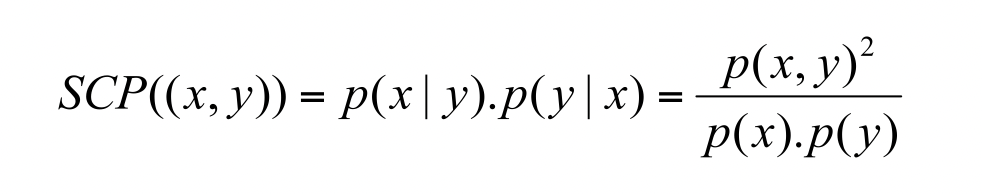
    - $scp(n) \in [0,1]$
- Dice: 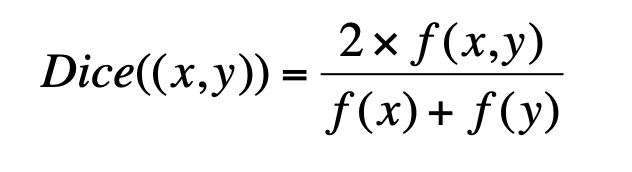
    - $dice(n) \in [0,1]$
- MI: 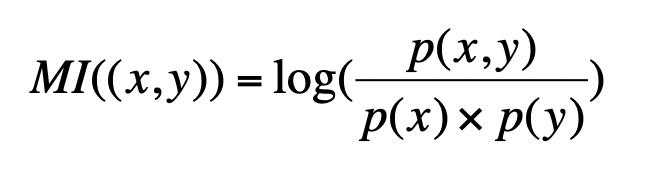
    - $MI(n) [0, \infty]$

For multi-word n-grams:
    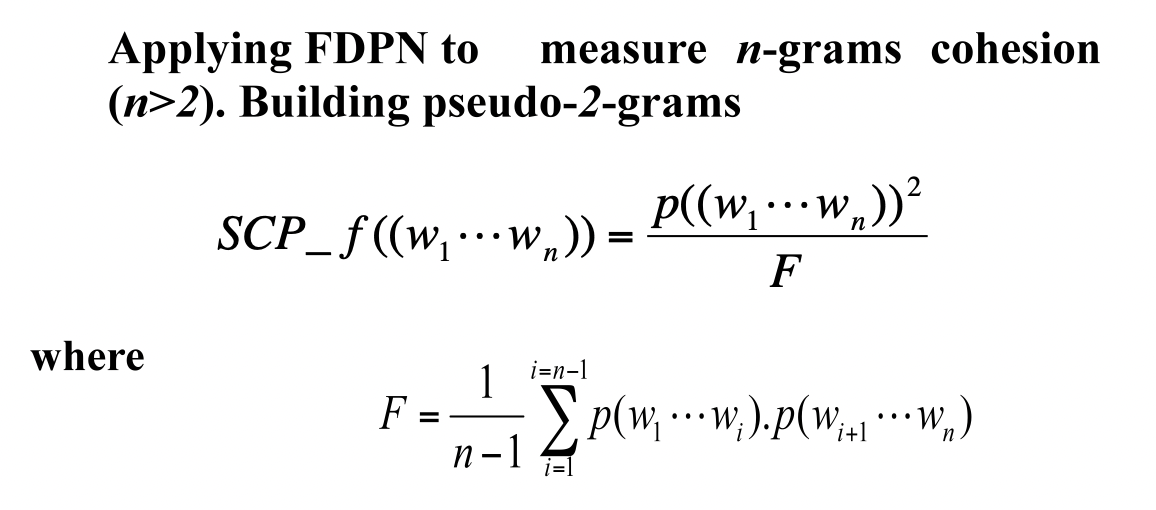

In [62]:
corpus_words = [word for doc_list in corpus.values() for word in doc_list]

2245476

In [66]:
def calculate_relative_frequency_of_n_gram(n_gram):
    n_gram_occur_in_corpus = len([n_gram for idx in range(len(corpus_words)) if corpus_words[idx : idx + len(n_gram)] == n_gram])
    p = n_gram_occur_in_corpus / len(corpus_words)
    return p

In [67]:
def scp_f(n_gram):
    p_squared = calculate_relative_frequency_of_n_gram(n_gram)**2
    sum_relative_freq = 0
    for i in range(0,len(n_gram)-1):
        p = calculate_relative_frequency_of_n_gram(n_gram[:i+1]) * calculate_relative_frequency_of_n_gram(n_gram[i+1:])
        sum_relative_freq = sum_relative_freq + p
    F = 1 / (len(n_gram) - 1) * sum_relative_freq
    scp_f = p_squared / F
    return scp_f

In [71]:
# currently always gives a division by Zero error
scp_f('he was a')

ZeroDivisionError: float division by zero